### homework 1: COVID-19 Cases Prediction (regression)

### download data
you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace

In [1085]:
tr_path = 'covid.train.csv'  # path to training data
tt_path = 'covid.test.csv'   # path to testing data

### import some packages

In [1086]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# for data preprocess
import numpy as np
import csv
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# for feature selection
import pandas as pd
import sklearn
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

myseed = 42069  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(myseed)

### some utilities
you do not need to modify this part

In [1087]:
def get_device():
  ''' get device (if GPU is available, use GPU) '''
  return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
  ''' plot learning curve of your DNN (train & dev loss) '''
  total_steps = len(loss_record['train'])
  x_1 = range(total_steps)
  x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
  figure(figsize=(6, 4))
  plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
  plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
  plt.ylim(0.0, 5.)
  plt.xlabel('training steps')
  plt.ylabel('MSE loss')
  plt.title('learning curve of {}'.format(title))
  plt.legend()
  plt.show()


def plot_pred(dv_set, model, device, lim=35., preds=None, targets=None):
  ''' plot prediction of your DNN '''
  if preds is None or targets is None:
    model.eval()
    preds, targets = [], []
    for x, y in dv_set:
      x, y = x.to(device), y.to(device)
      with torch.no_grad():
        pred = model(x)
        preds.append(pred.detach().cpu())
        targets.append(y.detach().cpu())
    preds = torch.cat(preds, dim=0).numpy()
    targets = torch.cat(targets, dim=0).numpy()

  figure(figsize=(5, 5))
  plt.scatter(targets, preds, c='r', alpha=0.5)
  plt.plot([-0.2, lim], [-0.2, lim], c='b')
  plt.xlim(-0.2, lim)
  plt.ylim(-0.2, lim)
  plt.xlabel('ground truth value')
  plt.ylabel('predicted value')
  plt.title('ground truth v.s. prediction')
  plt.show()

### preprocess
we have three kinds of datasets:
* train: for training
* dev: for validation
* test: for testing (w/o target value)

### feature selection

1. feature selection using correlation
2. feature selection using F-Test
3. feature selection using mutual information

  

In [1088]:
# feature selection using correlation
data_tr = pd.read_csv(tr_path) # read training data
data_tt = pd.read_csv(tt_path) # read testing data

data_tr.drop('id', axis=1, inplace=True) # drop 'id' column
data_tt.drop('id', axis=1, inplace=True)

data_corr = data_tr.iloc[:, 40:].corr()  # compute pairwise correlation of columns
target_col = data_corr['tested_positive.2']
feature = target_col[target_col > 0.8]

feature_cols = feature.index.tolist()  # get column name
feature_cols.pop()                     # remove test_positive 

cols = list(data_tr.columns)  # list of feature names

# get the index of the feature column
# which can be used as feats + feats_selected for feature values
feats_selected = [cols.index(col) for col in feature_cols]
feats_selected

[40, 41, 42, 43, 57, 58, 59, 60, 61, 75, 76, 77, 78, 79]

### Dataset
the COVID19Dataset below does:
* read `.csv` files
* extract features
* split `covid.train.csv` into train/dev sets
* normalize features

finishing TODO below might make you pass medium baseline

In [1089]:
class COVID19Dataset(Dataset):
  ''' Dataset for loading and preprocessing the COVID19 dataset '''

  def __init__(self,
               path,
               mode='train',
               target_only=False):
    self.mode = mode

    # read data into numpy arrays
    with open(path, 'r') as fp:
      data = list(csv.reader(fp))
      data = np.array(data[1:])[:, 1:].astype(float)

    if not target_only:
      feats = list(range(93))
    else:
      # TODO: using 40 states & 2 tested_positive features (indices = 57 & 75)
      # feats = list(range(40)) + [57, 75]
      feats = list(range(40)) + feats_selected

    if mode == 'test':
      # testing data
      # data: 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
      data = data[:, feats]
      self.data = torch.FloatTensor(data)
    else:
      # training data (train/dev sets)
      # data: 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (18))
      target = data[:, -1]
      data = data[:, feats]

      # splitting training data into train & dev sets
      if mode == 'train':
        indices = [i for i in range(len(data)) if i % 10 != 0]
      elif mode == 'dev':
        indices = [i for i in range(len(data)) if i % 10 == 0]
      
      # convert data into PyTorch tensors
      self.data = torch.FloatTensor(data[indices])
      self.target = torch.FloatTensor(target[indices])

    # normalize features (you may remove this part to see what will happen)
    self.data[:, 40:] = \
        (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
        / self.data[:, 40:].std(dim=0, keepdim=True)

    self.dim = self.data.shape[1]

    print('finished reading the {} set of COVID19 Dataset ({} samples found, each dim = {})'
          .format(mode, len(self.data), self.dim))

  def __getitem__(self, index):
    if self.mode in ['train', 'dev']:
      return self.data[index], self.target[index]
    else:
      return self.data[index]

  def __len__(self):
    return len(self.data)

### DataLoader
a DataLoader loads data from a given Dataset into batches.

In [1090]:
def prep_dataloader(path, mode, batch_size, n_jobs=0, target_only=False):
  ''' generates a dataset, then is put into a dataloader '''
  dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
  dataloader = DataLoader(dataset, batch_size,
                          shuffle=(mode == 'train'), drop_last=False,
                          num_workers=n_jobs, pin_memory=True)
  return dataloader

### deep neural network
`NeuralNet` is an nn.Module designed for regression. 

the DNN consists of 2 fully-connected layers with `ReLU` activation. 

this module also included a function `cal_loss` for calculating loss.

In [1091]:
class NeuralNet(nn.Module):
  ''' a simple fully-connected deep neural network '''

  def __init__(self, input_dim):
    super().__init__()

    # define your neural network here
    # TODO: how to modify this model to achieve better performance?
    self.net = nn.Sequential(
        nn.Linear(input_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

    # mean squared error loss
    self.criterion = nn.MSELoss(reduction='mean')
    self.lambda_l1 = 0.01
    self.lambda_l2 = 0.01

  def forward(self, x):
    ''' given input of size (batch_size x input_dim), compute output of the network '''
    return self.net(x).squeeze(1)

  def cal_loss(self, pred, target):
    ''' calculate loss '''
    # TODO: you may implement L1/L2 regularization here
    loss = self.criterion(pred, target)
    # L1 regularization
    '''
    l1_loss = 0
    for param in self.parameters():
      l1_loss += torch.sum(torch.abs(param))

    loss += self.lambda_l1 * l1_loss
    '''
    # L2 regularization
    l2_loss = 0
    for param in self.parameters():
      l2_loss += torch.sum(param ** 2)

    loss += self.lambda_l2 * l2_loss
    return loss

### training

In [1092]:
def train(tr_set, dv_set, model, config, device):
  ''' DNN training '''

  n_epochs = config['n_epochs']  # maximum number of epochs

  # setup optimizer
  optimizer = getattr(torch.optim, config['optimizer'])(
      model.parameters(), **config['optim_hparas'])

  min_mse = 1000.
  loss_record = {'train': [], 'dev': []}      # for recording training loss
  early_stop_cnt = 0
  epoch = 0
  while epoch < n_epochs:
    model.train()                           # set model to training mode
    for x, y in tr_set:                     # iterate through the dataloader
      optimizer.zero_grad()                 # set gradient to zero
      # move data to device (cpu/cuda)
      x, y = x.to(device), y.to(device)
      # forward pass (compute output)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)    # compute loss
      mse_loss.backward()                   # compute gradient (backpropagation)
      optimizer.step()                      # update model with optimizer
      loss_record['train'].append(mse_loss.detach().cpu().item())

    # after each epoch, test your model on the validation (development) set.
    dev_mse = dev(dv_set, model, device)
    if dev_mse < min_mse:
      # save model if your model improved
      min_mse = dev_mse
      print('saving model (epoch = {:4d}, loss = {:.4f})'
            .format(epoch + 1, min_mse))
      # save model to specified path
      torch.save(model.state_dict(), config['save_path'])
      early_stop_cnt = 0
    else:
      early_stop_cnt += 1

    epoch += 1
    loss_record['dev'].append(dev_mse)
    if early_stop_cnt > config['early_stop']:
      # stop training if your model stops improving for "config['early_stop']" epochs.
      break

  print('finished training after {} epochs'.format(epoch))
  return min_mse, loss_record

### validation

In [1093]:
def dev(dv_set, model, device):
  model.eval()                                # set model to evalutation mode
  total_loss = 0
  for x, y in dv_set:                         # iterate through the dataloader
    # move data to device (cpu/cuda)
    x, y = x.to(device), y.to(device)
    with torch.no_grad():                   # disable gradient calculation
      # forward pass (compute output)
      pred = model(x)
      mse_loss = model.cal_loss(pred, y)    # compute loss
    total_loss += mse_loss.detach().cpu().item() * len(x)  # accumulate loss
  # compute averaged loss
  total_loss = total_loss / len(dv_set.dataset)

  return total_loss

### testing

In [1094]:
def test(tt_set, model, device):
  model.eval()                                # set model to evalutation mode
  preds = []
  for x in tt_set:                            # iterate through the dataloader
    # move data to device (cpu/cuda)
    x = x.to(device)
    with torch.no_grad():                   # disable gradient calculation
      # forward pass (compute output)
      pred = model(x)
      preds.append(pred.detach().cpu())     # collect prediction
  # concatenate all predictions and convert to a numpy array
  preds = torch.cat(preds, dim=0).numpy()
  return preds

### setup hyper-parameters
config contains hyper-parameters for training and the path to save your model

In [1095]:
# get the current available device ('cpu' or 'cuda')
device = get_device()
# the trained model will be saved to ./models/
os.makedirs('models', exist_ok=True)
# TODO: using 40 states & 2 tested_positive features
target_only = True

# TODO: how to tune these hyper-parameters to improve your model's performance?
config = {
  'n_epochs': 3000,                # maximum number of epochs
  'batch_size': 270,               # mini-batch size for dataloader
  # optimization algorithm (optimizer in torch.optim)
  'optimizer': 'SGD',
  'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
    'lr': 0.001,                   # learning rate of SGD
    'momentum': 0.9                # momentum for SGD
  },
  # early stopping epochs (the number epochs since your model's last improvement)
  'early_stop': 200,
  'save_path': 'models/model.pth'  # your model will be saved here
}

### load data and model

In [1096]:
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

finished reading the train set of COVID19 Dataset (2430 samples found, each dim = 54)
finished reading the dev set of COVID19 Dataset (270 samples found, each dim = 54)
finished reading the test set of COVID19 Dataset (893 samples found, each dim = 54)


In [1097]:
model = NeuralNet(tr_set.dataset.dim).to(device)  # construct model and move to device

### start training!

In [1098]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

saving model (epoch =    1, loss = 141.4186)
saving model (epoch =    2, loss = 50.9660)
saving model (epoch =    3, loss = 24.4740)
saving model (epoch =    4, loss = 7.4482)
saving model (epoch =    5, loss = 5.1419)
saving model (epoch =    6, loss = 2.9153)
saving model (epoch =    7, loss = 2.2579)
saving model (epoch =    8, loss = 2.0718)
saving model (epoch =    9, loss = 1.9209)
saving model (epoch =   10, loss = 1.8596)
saving model (epoch =   11, loss = 1.8121)
saving model (epoch =   12, loss = 1.8046)
saving model (epoch =   13, loss = 1.7866)
saving model (epoch =   14, loss = 1.7622)
saving model (epoch =   15, loss = 1.7548)
saving model (epoch =   16, loss = 1.7356)
saving model (epoch =   17, loss = 1.7203)
saving model (epoch =   19, loss = 1.6936)
saving model (epoch =   20, loss = 1.6902)
saving model (epoch =   21, loss = 1.6824)
saving model (epoch =   22, loss = 1.6739)
saving model (epoch =   23, loss = 1.6602)
saving model (epoch =   25, loss = 1.6516)
saving 

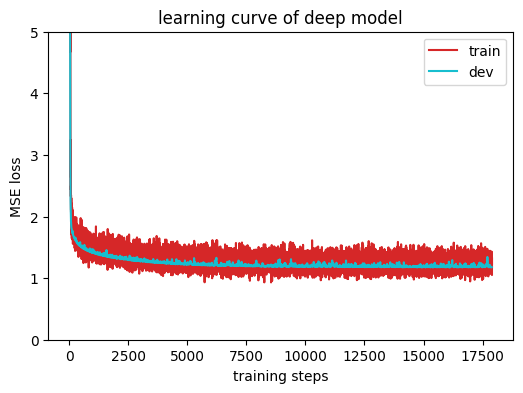

In [1099]:
plot_learning_curve(model_loss_record, title='deep model')

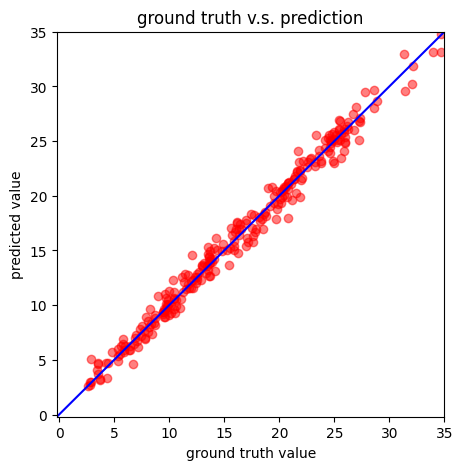

In [1100]:
del model
model = NeuralNet(tr_set.dataset.dim).to(device)
# load your best model
ckpt = torch.load(config['save_path'], map_location='cpu', weights_only=False)
model.load_state_dict(ckpt)
plot_pred(dv_set, model, device)  # show prediction on the validation set

### testing
the predictions of your model on testing set will be stored at `pred.csv`

In [1101]:
def save_pred(preds, file):
  ''' save predictions to specified file '''
  print('saving results to {}'.format(file))
  with open(file, 'w') as fp:
    writer = csv.writer(fp)
    writer.writerow(['id', 'tested_positive'])
    for i, p in enumerate(preds):
      writer.writerow([i, p])


preds = test(tt_set, model, device)  # predict COVID-19 cases with your model
save_pred(preds, 'pred.csv')         # save prediction file to pred.csv

saving results to pred.csv


### download
run this block to download the `pred.csv` by clicking

In [1102]:
from IPython.display import FileLink
FileLink(r'pred.csv')

/root/remy/learncode/dl/regression/pred.csv

### baseline
|         | Simple  | Medium  | Strong  |
|---------|---------|---------|---------|
| Score   | 2.04826 | 1.36937 | 0.89266 |

### simple baseline
run sample code, submit `pred.csv` to [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data).
get a **Public Score: 1.35374** and a **Private score: 1.43738**. surpassing the simple baseline score of **2.04826**

### medium baseline
* feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

submit `pred.csv` to [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data).
get a **Public Score: 1.05926** and a **Private score: 1.06473**. surpassing the simple baseline score of **1.36937**

### strong Baseline
* feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* training (mini-batch? optimizer? learning rate?)
* L2 regularization
* there are some mistakes in the sample code, can you find them?

#### feature selection

1. feature selection using correlation
2. feature selection using F-Test
3. feature selection using mutual information

In [1103]:
# feature selection using correlation
import pandas as pd
data_tr = pd.read_csv(tr_path) # read training data
data_tt = pd.read_csv(tt_path) # read testing data

In [1104]:
data_tr.head(5) # view the first 5 rows

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.812411,43.430423,16.151527,1.602635,15.409449,12.088688,16.702086,53.991549,43.604229,20.704935
1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.682974,43.196313,16.123386,1.641863,15.230063,11.809047,16.506973,54.185521,42.665766,21.292911
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23.593983,43.362200,16.159971,1.677523,15.717207,12.355918,16.273294,53.637069,42.972417,21.166656
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.576992,42.954574,15.544373,1.578030,15.295650,12.218123,16.045504,52.446223,42.907472,19.896607
4,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,22.091433,43.290957,15.214655,1.641667,14.778802,12.417256,16.134238,52.560315,43.321985,20.178428


In [1105]:
data_tt.head(5) # view the first 5 rows

,id,AL,AK,AZ,AR,CA,CO,CT,FL,GA,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,52.071090,8.624001,29.374792,5.391413,2.754804,19.695098,13.685645,24.747837,66.194950,44.873473
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,58.742461,21.720187,41.375784,9.450179,3.150088,22.075715,17.302077,23.559622,57.015009,38.372829
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.109045,20.123959,40.072556,8.781522,2.888209,23.920870,18.342506,24.993341,55.291498,38.907257
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,55.442267,16.083529,36.977612,5.199286,2.575347,21.073800,12.087171,18.608723,67.036197,43.142779
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,60.588783,19.503010,42.631236,11.549771,8.530551,15.896575,11.781634,15.065228,61.196518,43.574676


In [1106]:
data_tr.drop('id', axis=1, inplace=True) # drop 'id' column
data_tt.drop('id', axis=1, inplace=True)

In [1107]:
data_tr.info() #check the data types and sizes of each column


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 94 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AL                      2700 non-null   float64
 1   AK                      2700 non-null   float64
 2   AZ                      2700 non-null   float64
 3   AR                      2700 non-null   float64
 4   CA                      2700 non-null   float64
 5   CO                      2700 non-null   float64
 6   CT                      2700 non-null   float64
 7   FL                      2700 non-null   float64
 8   GA                      2700 non-null   float64
 9   ID                      2700 non-null   float64
 10  IL                      2700 non-null   float64
 11  IN                      2700 non-null   float64
 12  IA                      2700 non-null   float64
 13  KS                      2700 non-null   float64
 14  KY                      2700 non-null   

In [1108]:
data_tr.iloc[:, 40:].describe() # check the data distribution

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
count,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,...,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000,2700.000000
mean,0.991587,1.016136,29.442496,24.323054,89.682322,8.894498,31.703307,55.277153,16.694342,36.283177,...,16.578290,36.074941,10.257474,2.385735,18.067635,13.058828,19.243283,64.834307,44.568440,16.431280
std,0.420296,0.423629,9.093738,8.446750,5.380027,3.404027,4.928902,4.525917,5.668479,6.675206,...,5.651583,6.655166,4.686263,1.053147,2.250081,1.628589,2.708339,6.220087,5.232030,7.619354
min,0.126321,0.132470,9.961640,6.857181,70.950912,1.252983,18.311941,43.220187,3.637414,21.485815,...,3.637414,21.485815,2.118674,0.728770,12.980786,8.370536,13.400399,48.225603,33.113882,2.338708
25%,0.673929,0.697515,23.203165,18.539153,86.309537,6.177754,28.247865,51.547206,13.311050,30.740931,...,13.200532,30.606711,6.532543,1.714080,16.420485,11.914167,17.322912,59.782876,40.549987,10.327314
50%,0.912747,0.940295,28.955738,23.819761,90.819435,8.288288,32.143140,55.257262,16.371699,36.267966,...,16.227010,36.041389,9.700368,2.199521,17.684197,12.948749,18.760267,65.932259,43.997637,15.646480
75%,1.266849,1.302040,36.109114,30.238061,93.937119,11.582209,35.387315,58.866130,21.396971,41.659971,...,21.207162,41.508520,13.602566,2.730469,19.503419,14.214320,20.713638,69.719651,48.118283,22.535165
max,2.597732,2.625885,56.832289,51.550450,98.087160,18.552325,42.359074,65.673889,28.488220,50.606465,...,28.488220,50.606465,24.496711,8.162275,28.574091,18.715944,28.366270,77.701014,58.433600,40.959495


In [1109]:
# compare the test set distribution with the training set; 
# the differences in feature distributions are not significant
data_tt.iloc[:, 40:].describe() # check the data distribution

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,shop.2,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2
count,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,...,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000,893.000000
mean,0.972457,0.991809,29.075682,24.018729,89.637506,9.001325,31.620607,55.422982,16.554387,36.371653,...,55.268628,16.444916,36.165898,10.248975,2.369115,17.988147,12.993830,19.238723,64.619920,44.411505
std,0.411997,0.415468,9.596290,8.988245,4.733549,3.655616,4.754570,4.366780,5.688802,6.203232,...,4.350540,5.656828,6.192274,4.498845,1.114366,2.207022,1.713143,2.687435,5.685865,4.605268
min,0.139558,0.159477,9.171315,6.014740,76.895278,2.062500,18.299198,44.062442,3.800684,21.487077,...,44.671891,3.837441,21.338425,2.334655,0.873986,12.696977,8.462444,13.476209,50.212234,35.072577
25%,0.673327,0.689367,21.831730,17.385490,86.587475,7.055039,28.755178,51.726987,13.314242,31.427591,...,51.594301,13.391769,31.330469,6.802860,1.760374,16.406397,11.777101,17.197313,60.358203,40.910546
50%,0.925230,0.936610,28.183014,23.035749,90.123133,8.773243,31.826385,55.750887,17.100556,36.692799,...,55.490325,16.975410,36.213594,9.550393,2.146468,17.719760,12.805424,19.068658,65.148128,44.504010
75%,1.251219,1.267463,36.813772,31.141866,93.387952,10.452262,35.184926,59.185350,20.919961,41.265159,...,59.078475,20.584376,41.071035,13.372731,2.645314,19.423720,14.091551,21.205695,68.994309,47.172065
max,2.488967,2.522263,53.184067,48.142433,97.843221,26.598752,42.887263,63.979007,27.438286,53.513289,...,63.771097,27.362321,52.045373,23.305630,9.118302,27.003564,18.964157,26.007557,76.871053,56.442135


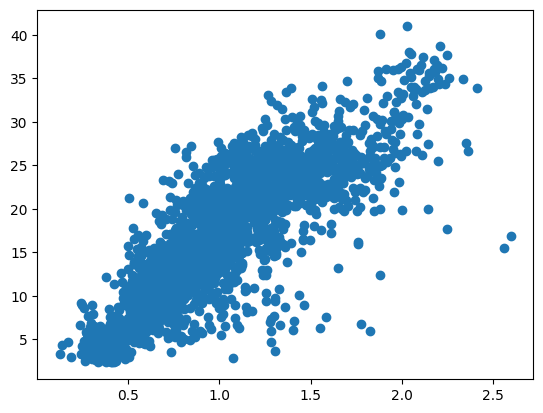

In [1110]:
# manually check the correlation between cli features and the target variable
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'tested_positive.2'])


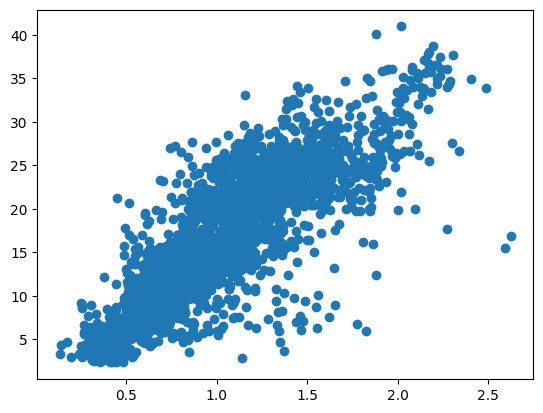

In [1111]:
plt.scatter(data_tr.loc[:, 'ili'], data_tr.loc[:, 'tested_positive.2'])

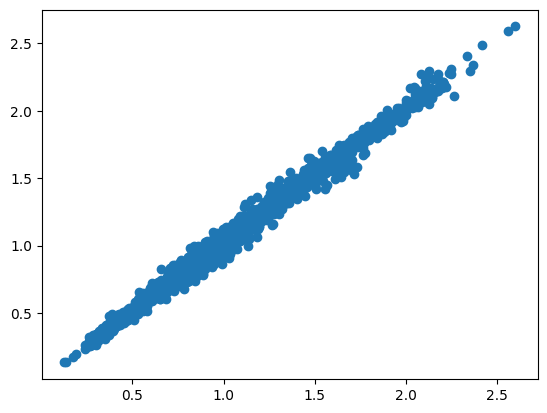

In [1112]:
# cli and ili are similar, so we can use just one of these features
plt.scatter(data_tr.loc[:, 'cli'], data_tr.loc[:, 'ili'])

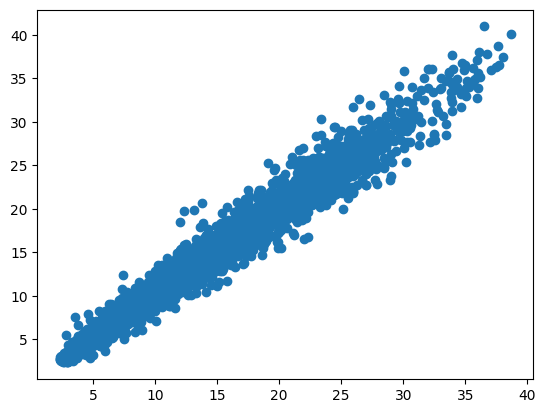

In [1113]:
# the correlation between day 1 and day 3 target values is linear
plt.scatter(data_tr.loc[:,  'tested_positive'], data_tr.loc[:, 'tested_positive.2']) 

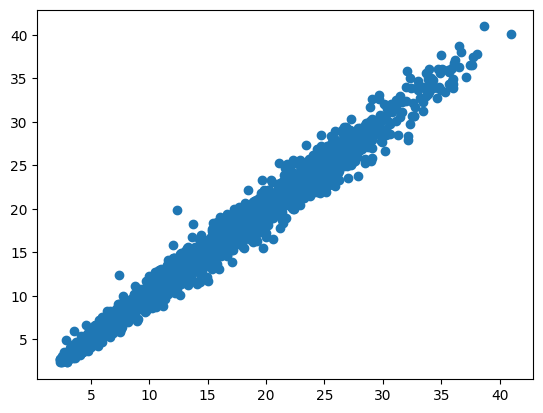

In [1114]:
# the correlation between day 2 and day 3 target values is linear
plt.scatter(data_tr.loc[:,  'tested_positive.1'], data_tr.loc[:, 'tested_positive.2'])

In [1115]:
# manual analysis above is too tedious
# let's use the corr method for automated analysis instead
data_tr.iloc[:, 40:].corr() # compute pairwise correlation of columns

,cli,ili,hh_cmnty_cli,nohh_cmnty_cli,wearing_mask,travel_outside_state,work_outside_home,shop,restaurant,spent_time,...,restaurant.2,spent_time.2,large_event.2,public_transit.2,anxious.2,depressed.2,felt_isolated.2,worried_become_ill.2,worried_finances.2,tested_positive.2
cli,1.000000,0.995735,0.893416,0.882322,-0.107406,-0.095964,0.087305,-0.364165,-0.143318,-0.209020,...,-0.151291,-0.222834,-0.060308,-0.374071,0.237135,0.081456,0.098345,0.228750,0.550564,0.838504
ili,0.995735,1.000000,0.889729,0.878280,-0.109015,-0.106934,0.086355,-0.357443,-0.142082,-0.207210,...,-0.150141,-0.220942,-0.061298,-0.363873,0.245228,0.086229,0.104250,0.222909,0.544776,0.830527
hh_cmnty_cli,0.893416,0.889729,1.000000,0.997225,-0.035441,-0.069595,0.079219,-0.472746,-0.247043,-0.293775,...,-0.253615,-0.300062,-0.136937,-0.433276,0.307581,0.181497,0.203577,0.350255,0.561942,0.879724
nohh_cmnty_cli,0.882322,0.878280,0.997225,1.000000,-0.046063,-0.061914,0.097756,-0.465374,-0.238106,-0.280916,...,-0.245265,-0.287482,-0.129474,-0.424996,0.317836,0.188467,0.203599,0.345448,0.534711,0.869938
wearing_mask,-0.107406,-0.109015,-0.035441,-0.046063,1.000000,-0.220808,-0.735649,-0.691597,-0.788714,-0.807623,...,-0.785281,-0.802659,-0.889021,0.133487,0.204031,-0.067720,0.427533,0.840528,0.340101,-0.069531
travel_outside_state,-0.095964,-0.106934,-0.069595,-0.061914,-0.220808,1.000000,0.264107,0.256911,0.288473,0.349829,...,0.288098,0.336937,0.319736,-0.203611,0.001592,0.064425,-0.370776,-0.131961,-0.093096,-0.097303
work_outside_home,0.087305,0.086355,0.079219,0.097756,-0.735649,0.264107,1.000000,0.631958,0.743673,0.698047,...,0.730349,0.705533,0.758575,-0.110176,0.018259,0.075562,-0.430307,-0.652231,-0.317717,0.034865
shop,-0.364165,-0.357443,-0.472746,-0.465374,-0.691597,0.256911,0.631958,1.000000,0.820916,0.819035,...,0.811055,0.838358,0.787237,0.130046,-0.228007,-0.029168,-0.496368,-0.866789,-0.475304,-0.410430
restaurant,-0.143318,-0.142082,-0.247043,-0.238106,-0.788714,0.288473,0.743673,0.820916,1.000000,0.878576,...,0.993358,0.876107,0.909089,-0.046081,-0.278715,-0.074727,-0.648631,-0.832131,-0.430842,-0.157945
spent_time,-0.209020,-0.207210,-0.293775,-0.280916,-0.807623,0.349829,0.698047,0.819035,0.878576,1.000000,...,0.875365,0.986713,0.912682,-0.040623,-0.169965,0.105281,-0.517139,-0.867460,-0.522985,-0.252125


In [1116]:
# select the last column of the correlation matrix to 
# view the correlation of other features with the target value.
data_corr = data_tr.iloc[:, 40:].corr()
target_col = data_corr['tested_positive.2']
target_col

cli                       0.838504
ili                       0.830527
hh_cmnty_cli              0.879724
nohh_cmnty_cli            0.869938
wearing_mask             -0.069531
travel_outside_state     -0.097303
work_outside_home         0.034865
shop                     -0.410430
restaurant               -0.157945
spent_time               -0.252125
large_event              -0.052473
public_transit           -0.448360
anxious                   0.173295
depressed                 0.037689
felt_isolated             0.082182
worried_become_ill        0.262211
worried_finances          0.475462
tested_positive           0.981165
cli.1                     0.838224
ili.1                     0.829200
hh_cmnty_cli.1            0.879438
nohh_cmnty_cli.1          0.869278
wearing_mask.1           -0.065600
travel_outside_state.1   -0.100407
work_outside_home.1       0.037930
shop.1                   -0.412705
restaurant.1             -0.159121
spent_time.1             -0.255714
large_event.1       

In [1117]:
# select features with a correlation greater than 0.8
# the threshold can be adjusted as needed.
feature = target_col[target_col > 0.8]
feature

cli                  0.838504
ili                  0.830527
hh_cmnty_cli         0.879724
nohh_cmnty_cli       0.869938
tested_positive      0.981165
cli.1                0.838224
ili.1                0.829200
hh_cmnty_cli.1       0.879438
nohh_cmnty_cli.1     0.869278
tested_positive.1    0.991012
cli.2                0.835751
ili.2                0.826075
hh_cmnty_cli.2       0.878218
nohh_cmnty_cli.2     0.867535
tested_positive.2    1.000000
Name: tested_positive.2, dtype: float64

In [1118]:
feature_cols = feature.index.tolist()  # get column name
feature_cols.pop()                     # remove test_positive 
feature_cols


['cli',
 'ili',
 'hh_cmnty_cli',
 'nohh_cmnty_cli',
 'tested_positive',
 'cli.1',
 'ili.1',
 'hh_cmnty_cli.1',
 'nohh_cmnty_cli.1',
 'tested_positive.1',
 'cli.2',
 'ili.2',
 'hh_cmnty_cli.2',
 'nohh_cmnty_cli.2']

In [1119]:
cols = list(data_tr.columns)  # list of feature names

# get the index of the feature column
# which can be used as feats + feats_selected for feature values
feats_selected = [cols.index(col) for col in feature_cols]
for col, index in zip(feature_cols, feats_selected):
  print(f"{index:>4}, {col:>15}")

  40,             cli
  41,             ili
  42,    hh_cmnty_cli
  43,  nohh_cmnty_cli
  57, tested_positive
  58,           cli.1
  59,           ili.1
  60,  hh_cmnty_cli.1
  61, nohh_cmnty_cli.1
  75, tested_positive.1
  76,           cli.2
  77,           ili.2
  78,  hh_cmnty_cli.2
  79, nohh_cmnty_cli.2


In [1120]:
# feature selection using F-Test

data = pd.read_csv('covid.train.csv')
x = data.iloc[:, 1:94]  
y = data.iloc[:, 94]

# normalisation
x = (x - x.min()) / (x.max() - x.min())

# create an instance of SelectKBest without specifying 'k'
selector = SelectKBest(score_func=f_regression)

# compute the scores for all features
selector.fit(x, y)

feature_scores = pd.DataFrame({'Feature': x.columns, 'Score': selector.scores_})
top_features = feature_scores.nlargest(15, 'Score')
print(top_features.sort_index())


               Feature          Score
40                 cli    6388.906849
41                 ili    5998.922880
42        hh_cmnty_cli    9235.492094
43      nohh_cmnty_cli    8395.421300
57     tested_positive   69603.872591
58               cli.1    6374.548000
59               ili.1    5937.588576
60      hh_cmnty_cli.1    9209.019558
61    nohh_cmnty_cli.1    8343.255927
75   tested_positive.1  148069.658278
76               cli.2    6250.008702
77               ili.2    5796.947672
78      hh_cmnty_cli.2    9097.375172
79    nohh_cmnty_cli.2    8208.176435
92  worried_finances.2     833.613191


In [1121]:

data = pd.read_csv('covid.train.csv')
x = data.iloc[:, 1:94]  
y = data.iloc[:, 94]

# normalisation
x = (x - x.min()) / (x.max() - x.min())

# create an instance of SelectKBest without specifying 'k'
selector = SelectKBest(score_func=mutual_info_regression)

selector.fit(x, y)

feature_scores = pd.DataFrame({'Feature': x.columns, 'Score': selector.scores_})
top_features = feature_scores.nlargest(15, 'Score')
print(top_features.sort_index())

              Feature     Score
40                cli  0.755306
41                ili  0.732602
42       hh_cmnty_cli  0.974405
43     nohh_cmnty_cli  0.967455
57    tested_positive  1.664484
58              cli.1  0.767734
59              ili.1  0.743955
60     hh_cmnty_cli.1  0.971703
61   nohh_cmnty_cli.1  0.956408
75  tested_positive.1  2.047044
76              cli.2  0.740318
77              ili.2  0.763470
78     hh_cmnty_cli.2  0.980106
79   nohh_cmnty_cli.2  0.960308
84       restaurant.2  0.551291
